huggingface 패키지를 Colab에 설치합니다

In [ ]:
!pip install transformers
!pip install sentencepiece
!pip install tensorflow_addons

     |████████████████████████████████| 3.4 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 47.0 MB/s 
     |████████████████████████████████| 596 kB 48.6 MB/s 
     |████████████████████████████████| 61 kB 490 kB/s 
     |████████████████████████████████| 3.3 MB 35.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.3 MB/s 
     |████████████████████████████████| 1.1 MB 5.3 MB/s 


텐서플로우 2와 필요한 모듈들을 임포트합니다.  
최근에 텐서플로우 기본 버전은 2로 바뀌었습니다.

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from transformers import *
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import sentencepiece as spm
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import logging

구글 드라이브와 Colab을 연동합니다.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/Mydrive/')

Mounted at /content/Mydrive/


딥러닝 훈련에 사용 할 train 데이터와 test 데이터를 pandas dataframe 형식으로 불러옵니다.

In [ ]:
data = pd.read_csv("/content/Mydrive/MyDrive/1129/HS_train.tsv", sep = '\t')

data_x = data['comments']
data_y = data['hate']

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y,
                 stratify = data_y, 
                 test_size = 0.3,
                 random_state = 15)

train = pd.concat([X_train, y_train], axis=1).reset_index()
test = pd.concat([X_test, y_test], axis=1).reset_index()

print(f'Train: {train.shape}')
print(f'Test: {test.shape}')

Train: (3777, 3)
Test: (1620, 3)


In [ ]:
test

,index,comments,hate
0,830,새로운시작을 가장한 신적폐 문재인,hate
1,50,ㅇㅣ아즘마는 조용히 살고 싶다면서 왜 자꾸 기어나와? 돈도 많이벌었다고 예능에서 깝...,hate
2,2626,너무 화면에서 자주 봐서 그런건지...연기톤이 일정한 느낌...,none
3,4313,윤성한 아프리카 개노잼..,none
4,1893,홍인들 사진을 왜보여주냐 기자야 홍인 냄시,hate
...,...,...,...
1615,4343,응원해요.~요즘 안재현소속사가 혜선씨 소식 올라올까봐 제일 불안하겠네요,none
1616,1518,잘했어. 콘돔홍보대사로 발탁해라.,hate
1617,2892,로이킴은 아니라며... 아니라며!!,none
1618,4576,이효리씨 방송에서 술 맥주 소주 등등암만 가벼운 음주라도 삼가해주세요좀 보기안좋네요...,none


## 버트 인풋 만들기

한글 데이터를 분석하려면, 100개가 넘는 언어에 대해 훈련된 버트를 사용해야 합니다.  
이번에는 한국어 데이터로 훈련되었고, SKT에서 만든 KoBERT를 사용하도록 하겠습니다.  
모델을 로드하기에 앞서, 토크나이저를 불러오도록 하겠습니다.  
huggingface에서는 아주 쉽게 토크나이저를 불러올 수 있습니다.  
https://github.com/monologg/KoBERT-NER 에서 kobert를 tokenize 할 수 있는 코드를 가져왔습니다.

In [ ]:
import logging
import os
import unicodedata
from shutil import copyfile

from transformers import PreTrainedTokenizer


logger = logging.getLogger(__name__)

VOCAB_FILES_NAMES = {"vocab_file": "tokenizer_78b3253a26.model",
                     "vocab_txt": "vocab.txt"}

PRETRAINED_VOCAB_FILES_MAP = {
    "vocab_file": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/tokenizer_78b3253a26.model",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/tokenizer_78b3253a26.model",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/tokenizer_78b3253a26.model"
    },
    "vocab_txt": {
        "monologg/kobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert/vocab.txt",
        "monologg/kobert-lm": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/kobert-lm/vocab.txt",
        "monologg/distilkobert": "https://s3.amazonaws.com/models.huggingface.co/bert/monologg/distilkobert/vocab.txt"
    }
}

PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES = {
    "monologg/kobert": 512,
    "monologg/kobert-lm": 512,
    "monologg/distilkobert": 512
}

PRETRAINED_INIT_CONFIGURATION = {
    "monologg/kobert": {"do_lower_case": False},
    "monologg/kobert-lm": {"do_lower_case": False},
    "monologg/distilkobert": {"do_lower_case": False}
}

SPIECE_UNDERLINE = u'▁'


class KoBertTokenizer(PreTrainedTokenizer):
    """
        SentencePiece based tokenizer. Peculiarities:
            - requires `SentencePiece <https://github.com/google/sentencepiece>`_
    """
    vocab_files_names = VOCAB_FILES_NAMES
    pretrained_vocab_files_map = PRETRAINED_VOCAB_FILES_MAP
    pretrained_init_configuration = PRETRAINED_INIT_CONFIGURATION
    max_model_input_sizes = PRETRAINED_POSITIONAL_EMBEDDINGS_SIZES

    def __init__(
            self,
            vocab_file,
            vocab_txt,
            do_lower_case=False,
            remove_space=True,
            keep_accents=False,
            unk_token="[UNK]",
            sep_token="[SEP]",
            pad_token="[PAD]",
            cls_token="[CLS]",
            mask_token="[MASK]",
            **kwargs):
        super().__init__(
            unk_token=unk_token,
            sep_token=sep_token,
            pad_token=pad_token,
            cls_token=cls_token,
            mask_token=mask_token,
            **kwargs
        )

        # Build vocab
        self.token2idx = dict()
        self.idx2token = []
        with open(vocab_txt, 'r', encoding='utf-8') as f:
            for idx, token in enumerate(f):
                token = token.strip()
                self.token2idx[token] = idx
                self.idx2token.append(token)

        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")

        self.do_lower_case = do_lower_case
        self.remove_space = remove_space
        self.keep_accents = keep_accents
        self.vocab_file = vocab_file
        self.vocab_txt = vocab_txt

        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(vocab_file)

    @property
    def vocab_size(self):
        return len(self.idx2token)

    def get_vocab(self):
        return dict(self.token2idx, **self.added_tokens_encoder)

    def __getstate__(self):
        state = self.__dict__.copy()
        state["sp_model"] = None
        return state

    def __setstate__(self, d):
        self.__dict__ = d
        try:
            import sentencepiece as spm
        except ImportError:
            logger.warning("You need to install SentencePiece to use KoBertTokenizer: https://github.com/google/sentencepiece"
                           "pip install sentencepiece")
        self.sp_model = spm.SentencePieceProcessor()
        self.sp_model.Load(self.vocab_file)

    def preprocess_text(self, inputs):
        if self.remove_space:
            outputs = " ".join(inputs.strip().split())
        else:
            outputs = inputs
        outputs = outputs.replace("``", '"').replace("''", '"')

        if not self.keep_accents:
            outputs = unicodedata.normalize('NFKD', outputs)
            outputs = "".join([c for c in outputs if not unicodedata.combining(c)])
        if self.do_lower_case:
            outputs = outputs.lower()

        return outputs

    def _tokenize(self, text, return_unicode=True, sample=False):
        """ Tokenize a string. """
        text = self.preprocess_text(text)

        if not sample:
            pieces = self.sp_model.EncodeAsPieces(text)
        else:
            pieces = self.sp_model.SampleEncodeAsPieces(text, 64, 0.1)
        new_pieces = []
        for piece in pieces:
            if len(piece) > 1 and piece[-1] == str(",") and piece[-2].isdigit():
                cur_pieces = self.sp_model.EncodeAsPieces(piece[:-1].replace(SPIECE_UNDERLINE, ""))
                if piece[0] != SPIECE_UNDERLINE and cur_pieces[0][0] == SPIECE_UNDERLINE:
                    if len(cur_pieces[0]) == 1:
                        cur_pieces = cur_pieces[1:]
                    else:
                        cur_pieces[0] = cur_pieces[0][1:]
                cur_pieces.append(piece[-1])
                new_pieces.extend(cur_pieces)
            else:
                new_pieces.append(piece)

        return new_pieces

    def _convert_token_to_id(self, token):
        """ Converts a token (str/unicode) in an id using the vocab. """
        return self.token2idx.get(token, self.token2idx[self.unk_token])

    def _convert_id_to_token(self, index, return_unicode=True):
        """Converts an index (integer) in a token (string/unicode) using the vocab."""
        return self.idx2token[index]

    def convert_tokens_to_string(self, tokens):
        """Converts a sequence of tokens (strings for sub-words) in a single string."""
        out_string = "".join(tokens).replace(SPIECE_UNDERLINE, " ").strip()
        return out_string

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        """
        Build model inputs from a sequence or a pair of sequence for sequence classification tasks
        by concatenating and adding special tokens.
        A KoBERT sequence has the following format:
            single sequence: [CLS] X [SEP]
            pair of sequences: [CLS] A [SEP] B [SEP]
        """
        if token_ids_1 is None:
            return [self.cls_token_id] + token_ids_0 + [self.sep_token_id]
        cls = [self.cls_token_id]
        sep = [self.sep_token_id]
        return cls + token_ids_0 + sep + token_ids_1 + sep

    def get_special_tokens_mask(self, token_ids_0, token_ids_1=None, already_has_special_tokens=False):
        """
        Retrieves sequence ids from a token list that has no special tokens added. This method is called when adding
        special tokens using the tokenizer ``prepare_for_model`` or ``encode_plus`` methods.
        Args:
            token_ids_0: list of ids (must not contain special tokens)
            token_ids_1: Optional list of ids (must not contain special tokens), necessary when fetching sequence ids
                for sequence pairs
            already_has_special_tokens: (default False) Set to True if the token list is already formated with
                special tokens for the model
        Returns:
            A list of integers in the range [0, 1]: 0 for a special token, 1 for a sequence token.
        """

        if already_has_special_tokens:
            if token_ids_1 is not None:
                raise ValueError(
                    "You should not supply a second sequence if the provided sequence of "
                    "ids is already formated with special tokens for the model."
                )
            return list(map(lambda x: 1 if x in [self.sep_token_id, self.cls_token_id] else 0, token_ids_0))

        if token_ids_1 is not None:
            return [1] + ([0] * len(token_ids_0)) + [1] + ([0] * len(token_ids_1)) + [1]
        return [1] + ([0] * len(token_ids_0)) + [1]

    def create_token_type_ids_from_sequences(self, token_ids_0, token_ids_1=None):
        """
        Creates a mask from the two sequences passed to be used in a sequence-pair classification task.
        A KoBERT sequence pair mask has the following format:
        0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
        | first sequence    | second sequence
        if token_ids_1 is None, only returns the first portion of the mask (0's).
        """
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        if token_ids_1 is None:
            return len(cls + token_ids_0 + sep) * [0]
        return len(cls + token_ids_0 + sep) * [0] + len(token_ids_1 + sep) * [1]

    def save_vocabulary(self, save_directory):
        """ Save the sentencepiece vocabulary (copy original file) and special tokens file
            to a directory.
        """
        if not os.path.isdir(save_directory):
            logger.error("Vocabulary path ({}) should be a directory".format(save_directory))
            return

        # 1. Save sentencepiece model
        out_vocab_model = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_file"])

        if os.path.abspath(self.vocab_file) != os.path.abspath(out_vocab_model):
            copyfile(self.vocab_file, out_vocab_model)

        # 2. Save vocab.txt
        index = 0
        out_vocab_txt = os.path.join(save_directory, VOCAB_FILES_NAMES["vocab_txt"])
        with open(out_vocab_txt, "w", encoding="utf-8") as writer:
            for token, token_index in sorted(self.token2idx.items(), key=lambda kv: kv[1]):
                if index != token_index:
                    logger.warning(
                        "Saving vocabulary to {}: vocabulary indices are not consecutive."
                        " Please check that the vocabulary is not corrupted!".format(out_vocab_txt)
                    )
                    index = token_index
                writer.write(token + "\n")
                index += 1

        return out_vocab_model, out_vocab_txt

kobert 토크나이즈를 임포트합니다.

In [ ]:
tokenizer = KoBertTokenizer.from_pretrained('monologg/kobert')

Downloading:   0%|          | 0.00/363k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/76.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'KoBertTokenizer'.


버트를 사용하기에 앞서 가장 기초에 속하는 tokenizer 사용 방법에 대해서 잠시 배워보도록 하겠습니다.  
tokenizer.encode => 문장을 버트 모델의 인풋 토큰값으로 바꿔줌  
tokenizer.tokenize => 문장을 토큰화

In [ ]:
def convert_data(data_df):
    global tokenizer
    
    SEQ_LEN = 128 #SEQ_LEN : 버트에 들어갈 인풋의 길이
    
    tokens, masks, segments, targets = [], [], [], []
    
    for i in tqdm(range(len(data_df))):
        # token : 문장을 토큰화함
        token = tokenizer.encode(data_df[DATA_COLUMN][i], truncation=True, padding='max_length', max_length=SEQ_LEN)
       
        # 마스크는 토큰화한 문장에서 패딩이 아닌 부분은 1, 패딩인 부분은 0으로 통일
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        
        # 문장의 전후관계를 구분해주는 세그먼트는 문장이 1개밖에 없으므로 모두 0
        segment = [0]*SEQ_LEN

        # 버트 인풋으로 들어가는 token, mask, segment를 tokens, segments에 각각 저장
        tokens.append(token)
        masks.append(mask)
        segments.append(segment)
        
        # 정답(1 = 혐오표현,0 = 비혐오표현)을 targets 변수에 저장해 줌
        targets.append(data_df[LABEL_COLUMN][i])

    # tokens, masks, segments, 정답 변수 targets를 numpy array로 지정    
    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    targets = np.array(targets)

    return [tokens, masks, segments], targets

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_df[LABEL_COLUMN] = data_df[LABEL_COLUMN].astype(int)
    data_x, data_y = convert_data(data_df)
    return data_x, data_y

SEQ_LEN = 128
BATCH_SIZE = 32
# 긍부정 문장을 포함하고 있는 칼럼
DATA_COLUMN = "comments"
# 긍정인지 부정인지를 (1 = 혐오표현,0 = 비혐오표현) 포함하고 있는 칼럼
LABEL_COLUMN = "hate"

# train 데이터를 버트 인풋에 맞게 변환
train_x, train_y = load_data(train)

100%|██████████| 3777/3777 [00:02<00:00, 1495.34it/s]


In [ ]:
# 훈련 성능을 검증한 test 데이터를 버트 인풋에 맞게 변환
test_x, test_y = load_data(test)

100%|██████████| 1620/1620 [00:00<00:00, 3305.81it/s]


## 버트를 활용한 감성분석 모델 만들기

In [ ]:
model = TFBertModel.from_pretrained("monologg/kobert", from_pt=True)
# 토큰 인풋, 마스크 인풋, 세그먼트 인풋 정의
token_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_word_ids')
mask_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_masks')
segment_inputs = tf.keras.layers.Input((SEQ_LEN,), dtype=tf.int32, name='input_segment')

# 인풋이 [토큰, 마스크, 세그먼트]인 모델 정의
bert_outputs = model([token_inputs, mask_inputs, segment_inputs])
bert_outputs = bert_outputs[1]
bert_outputs

Downloading:   0%|          | 0.00/352M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertModel.

All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'tf_bert_model')>

In [ ]:
sentiment_drop = tf.keras.layers.Dropout(0.5)(bert_outputs)
sentiment_first = tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02))(sentiment_drop)
sentiment_model = tf.keras.Model([token_inputs, mask_inputs, segment_inputs], sentiment_first)

opt = tfa.optimizers.RectifiedAdam(lr=5.0e-5, total_steps = 2344*2, warmup_proportion=0.1, min_lr=1e-5, epsilon=1e-08, clipnorm=1.0)
sentiment_model.compile(optimizer=opt, loss=tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 input_segment (InputLayer)     [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  92186880    ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_masks[0][0]',        

/usr/local/lib/python3.7/dist-packages/tensorflow_addons/optimizers/rectified_adam.py:120: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


## 훈련 및 성능 검증

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5, restore_best_weights = True)
sentiment_model.fit(train_x, train_y, epochs=10, shuffle=True, batch_size=32, callbacks=[es], validation_data=(test_x, test_y))

Epoch 1/10
119/119 [==============================] - 271s 2s/step - loss: 0.6562 - accuracy: 0.6262 - val_loss: 0.6381 - val_accuracy: 0.6481
Epoch 2/10
119/119 [==============================] - 266s 2s/step - loss: 0.6268 - accuracy: 0.6645 - val_loss: 0.5634 - val_accuracy: 0.7327
Epoch 3/10
119/119 [==============================] - 266s 2s/step - loss: 0.6309 - accuracy: 0.6672 - val_loss: 0.5841 - val_accuracy: 0.6944
Epoch 4/10
119/119 [==============================] - 266s 2s/step - loss: 0.5303 - accuracy: 0.7434 - val_loss: 0.5793 - val_accuracy: 0.7068
Epoch 5/10
119/119 [==============================] - 267s 2s/step - loss: 0.3823 - accuracy: 0.8446 - val_loss: 0.4159 - val_accuracy: 0.8123
Epoch 6/10
119/119 [==============================] - 266s 2s/step - loss: 0.2931 - accuracy: 0.8907 - val_loss: 0.4183 - val_accuracy: 0.8173
Epoch 7/10
119/119 [==============================] - 266s 2s/step - loss: 0.2011 - accuracy: 0.9365 - val_loss: 0.5118 - val_accuracy: 0.8228

In [ ]:
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_masks (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 input_segment (InputLayer)     [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  92186880    ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_masks[0][0]',        

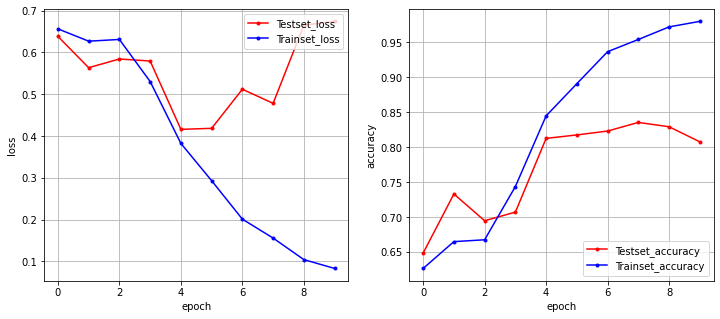

In [ ]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

# 오차
y_vloss = sentiment_model.history.history['val_loss']

# 학습셋 오차
y_loss = sentiment_model.history.history['loss']

# 그래프로 표현
x_len = np.arange(len(y_loss))
ax1.plot(x_len, y_vloss, marker = '.', c="red", label='Testset_loss')
ax1.plot(x_len, y_loss, marker = '.', c='blue', label = 'Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시
ax1.legend(loc='upper right')
ax1.grid()
ax1.set(xlabel='epoch', ylabel='loss')


# 정확도
y_vaccuracy = sentiment_model.history.history['val_accuracy']

# 학습셋
y_accuracy = sentiment_model.history.history['accuracy']

# 그래프로 표현
x_len = np.arange(len(y_accuracy))
ax2.plot(x_len, y_vaccuracy, marker = '.', c="red", label='Testset_accuracy')
ax2.plot(x_len, y_accuracy, marker = '.', c='blue', label = 'Trainset_accuracy')

# 그래프에 그리드를 주고 레이블을 표시
ax2.legend(loc='lower right')
ax2.grid()

ax2.set(xlabel='epoch', ylabel='accuracy')

# draw gridlines
ax2.grid(True)
plt.show()

훈련 모델의 예측 성능을 F1 SCORE로 체크하기 위한 작업

In [ ]:
def predict_convert_data(data_df):
    global tokenizer
    tokens, masks, segments = [], [], []
    
    for i in tqdm(range(len(data_df))):

        token = tokenizer.encode(data_df[DATA_COLUMN][i], max_length=SEQ_LEN, truncation=True, padding='max_length')
        num_zeros = token.count(0)
        mask = [1]*(SEQ_LEN-num_zeros) + [0]*num_zeros
        segment = [0]*SEQ_LEN

        tokens.append(token)
        segments.append(segment)
        masks.append(mask)

    tokens = np.array(tokens)
    masks = np.array(masks)
    segments = np.array(segments)
    return [tokens, masks, segments]

# 위에 정의한 convert_data 함수를 불러오는 함수를 정의
def predict_load_data(pandas_dataframe):
    data_df = pandas_dataframe
    data_df[DATA_COLUMN] = data_df[DATA_COLUMN].astype(str)
    data_x = predict_convert_data(data_df)
    return data_x

# 각 지표 구하는 함수 구현
def model_evaluation(label, predict):
    cf_matrix = confusion_matrix(label, predict)
    Accuracy = (cf_matrix[0][0] + cf_matrix[1][1]) / sum(sum(cf_matrix))
    Precision = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[0][1])
    Recall = cf_matrix[1][1] / (cf_matrix[1][1] + cf_matrix[1][0])
    Specificity = cf_matrix[0][0] / (cf_matrix[0][0] + cf_matrix[0][1])
    F1_Score = (2 * Recall * Precision) / (Recall + Precision)
    
    print(f'Accuracy: {Accuracy}')
    print(f'Precision: {Precision}')
    print(f'Recall: {Recall}')
    print(f'Specificity: {Specificity}')
    print(f'F1_Score: {F1_Score}')

test 데이터 예측하기

In [ ]:
test2 = pd.read_csv('/content/Mydrive/MyDrive/1129/tsv_Counter speech.tsv', sep = '\t')
test_set = predict_load_data(test2)
proba = sentiment_model.predict(test_set)

test2['probability'] = proba
test2['pred'] = np.round(proba, 0)
test2

100%|██████████| 4139/4139 [00:01<00:00, 2598.02it/s]


,type,comments,hate,probability,pred
0,인종/국가,인종차별을 끝내기 위해 어느 때보다 우리 모두의 역할이 중요합니다 인종 종교 국적 ...,0,0.879423,1.0
1,인종/국가,WeLoveYouBlackArmy BlackLivesMatter 우리가 짐작도 못할...,0,0.190910,0.0
2,성별,세상의 모든 여성은 강하며 위대합니다 세계여성의날 IWD2021,0,0.796939,1.0
3,성별,페미니스트 반대말은 성차별주의자임. 모든 강대국에서 너무나도 당연하게 규정하는 사실...,0,0.869601,1.0
4,인종/국가,인종차별 없는 세상을 위해 Change is now BlackLivesMatter ...,0,0.841011,1.0
...,...,...,...,...,...
4134,장애,장애인혐오 조장하는 서울메트로~ 휠체어 이용자들이 지하철 타고내리는데 연착이된거면 ...,0,0.903114,1.0
4135,장애,휠체어로 지하철 이용=지연됨=시위이다=????? 대체 무슨 논리야 지연된다는 거 자...,0,0.320256,0.0
4136,장애,쓰레기 같은 장애인 혐오자들 트윗 보다 니네 들이 싸지르는 글이 더 나뻐.. 대한민...,0,0.919968,1.0
4137,장애,난 교통약자도 아닌데 서울지하철 타고 내리는게 너무 힘들어. 비장애인도 문 열자마자...,0,0.291171,0.0


In [ ]:
test2.to_csv('/content/Mydrive/MyDrive/1129/prediction_result_epoch10.csv')

In [ ]:
# 사고관련 --> 0을 출력
y_true = test2['hate']

model_evaluation(y_true, np.round(proba, 0))
confusion_matrix(y_true, np.round(proba, 0))

Accuracy: 0.42715631795119596
Precision: 0.0
Recall: nan
Specificity: 0.42715631795119596
F1_Score: nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars


array([[1768, 2371],
       [   0,    0]])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from itertools import product

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

validation_predictions = [np.argmax(i) for i in sentiment_model.predict(test_set)] #predictions
validation_labels = test2.label.values.tolist() #ground truth labels

cm_plot_labels = ['neutral', 'contradiction']
cm = confusion_matrix(y_true=validation_labels, y_pred=validation_predictions)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix Without Normalization')
# plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix With Normalization', normalize=True)

target_class = ['neutral' if label==0 else 'contradiction' for label in validation_labels]
prediction_class = ['neutral' if label==0 else 'contradiction' for label in validation_predictions]
print('\nClassification Report')
print(classification_report(y_true=target_class, y_pred=prediction_class))

AttributeError: ignored

In [ ]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)